🧠 Notebook Overview

This notebook builds and evaluates a machine learning model to predict CO₂ uptake of materials (e.g., MOFs or porous solids) at specific temperature and pressure conditions using material descriptors such as surface area and pore volume.
It uses a data-driven approach typical in materials informatics:

- Load and preprocess data
-Select meaningful features
- Train and tune a regression model
- Evaluate and visualize model performance

# 1 - Importing Libraries

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import seaborn as sns
import argparse
from tqdm import tqdm
from loguru import logger
import json # For saving model parameters

from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Integer


# 2 - Data ingestion and preprocessing stage
Loading the training dataset and standardizing the naming of features for readability, focusing on geometric descriptors.

In [22]:
def load_train():
    file_path_train = 'Data/train.csv'
    # Load the CSV into a pandas DataFrame
    df_train = pd.read_csv(file_path_train)
    df_train = df_train.rename(columns = {"ASA [m^2/cm^3]" : "ASA_vol",
                                        "NASA [m^2/cm^3]" : "NASA_vol",
                                        "POAV [cm^3/g]" : "POAV_grav",
                                        "PONAV [cm^3/g]" : "PONAV_grav",
                                        "density [g/cm^3]" : "density"}
                                        )

    df_train = df_train.drop_duplicates()
    descriptor_names = df_train.columns[1:-1].tolist()

    return df_train, descriptor_names

def load_test():
    file_path_test = 'Data/test.csv'
    # Load the CSV into a pandas DataFrame
    df_test = pd.read_csv(file_path_test)
    df_test = df_test.rename(columns = {"ASA [m^2/cm^3]" : "ASA_vol",
                                        "NASA [m^2/cm^3]" : "NASA_vol",
                                        "POAV [cm^3/g]" : "POAV_grav",
                                        "PONAV [cm^3/g]" : "PONAV_grav",
                                        "density [g/cm^3]" : "density"}
                                        )
    
    return df_test

def baseline_model(test_size = 0.2):
    df_train, descriptor_names = load_train()
    label = "CO2 uptake at 0.15 bar and 298K"
    X, y = df_train[descriptor_names], df_train[label]

    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    logger.info(f'R2: {r2_score(y_val, y_pred)}, MAE: {mean_absolute_error(y_val, y_pred)} mol/kg')

In [23]:
df_test = load_test()
df_test.head()

,MOFname,ASA_vol,Df,Di,Dif,NASA_vol,POAV_grav,POAVF,PONAV_grav,PONAVF,...,sum-f-lig-I-2,sum-f-lig-I-3,sum-f-lig-T-0,sum-f-lig-T-1,sum-f-lig-T-2,sum-f-lig-T-3,sum-f-lig-S-0,sum-f-lig-S-1,sum-f-lig-S-2,sum-f-lig-S-3
0,GEZYOB_clean,1713.860,4.53159,5.97203,5.97203,0.000,0.289729,0.42726,0.000000,0.00000,...,420.0,36.0,704.0,1160.0,492.0,36.0,98.0342,187.7660,168.5184,8.1252
1,OKAYAC_clean,0.000,3.57241,4.90891,4.90749,249.165,0.000000,0.00000,0.095668,0.14986,...,384.0,496.0,624.0,1552.0,2208.0,2416.0,54.5344,127.1056,190.9984,225.5280
2,WIYWEI_clean,673.702,3.86066,5.60421,5.60126,0.000,0.157429,0.23456,0.000000,0.00000,...,984.0,1264.0,1568.0,3992.0,6120.0,7408.0,119.4744,284.0568,445.6024,543.6272
3,VUKROK_clean,1795.100,8.88276,10.23625,10.23453,0.000,0.918206,0.63930,0.000000,0.00000,...,456.0,588.0,724.0,1848.0,2728.0,2836.0,52.9216,127.9740,197.6120,223.3612
4,IJENER_clean,0.000,2.57734,6.00155,5.99535,751.919,0.000000,0.00000,0.184667,0.30384,...,416.0,392.0,672.0,1504.0,1888.0,2392.0,60.2032,133.5488,192.5568,226.5176


# 3 - Feature Selection (wrapper method)
An XGBoost Regressor is trained once to estimate feature importance and how much each descriptor contributes to predicting CO₂ uptake.
Only features with importance > 0.01 are kept, which helps:
- Reduce dimensionality
- Improve model generalization
- Avoid overfitting

In [24]:
def feature_selection(SEED):
    df_train, descriptor_names = load_train()
    label = "CO2 uptake at 0.15 bar and 298K"
    X_train, y_train = df_train[descriptor_names], df_train[label]

    model = xgb.XGBRegressor(n_estimators = 100)

    cv = KFold(n_splits = 3, shuffle = True, random_state = SEED)
    selector = RFECV(
        estimator = model,
        step = 2,
        cv = cv,
        scoring = "neg_mean_absolute_error",
        n_jobs = -1,
        verbose = 1,
        min_features_to_select = 40
    )

    selector.fit(X_train, y_train)
    print(f"Optimal number of features: {selector.n_features_}")
    selected_mask = selector.support_
    selected_features = np.array(X_train.columns)[selected_mask] if hasattr(X_train, 'columns') else selected_mask

    return selected_features

def hyperparameter_tuning(selected_features):
    df_train, descriptor_names = load_train()
    label = "CO2 uptake at 0.15 bar and 298K"
    X_train, y_train = df_train[descriptor_names], df_train[label]

    X_train_selected = X_train[selected_features]
    cv = KFold(5, random_state=42, shuffle=True)
    reg = xgb.XGBRegressor(n_estimators = 100, objective = 'reg:absoluteerror', random_state = 42)

    search_spaces = {
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'max_depth': Integer(3, 10),
        'subsample': Real(0.1, 1.0, 'uniform'),
        'colsample_bytree': Real(0.1, 1.0, 'uniform'),  # subsample ratio of columns by tree
        'reg_lambda': Real(1e-6, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-6, 1.0, 'log-uniform'),
    }

    opt = BayesSearchCV(
        estimator=reg,
        search_spaces=search_spaces,
        scoring='neg_mean_absolute_error',
        cv=cv,
        n_iter=50,
        n_points=1,
        n_jobs=-1,
        verbose=10,
        return_train_score=False,
        refit=False,
        optimizer_kwargs={'base_estimator': 'GP'},
        random_state=42
    )

    opt.fit(X_train_selected, y_train)
    df_opt = pd.DataFrame(opt.cv_results_)
    best_score = opt.best_score_
    best_score_std = df_opt.iloc[opt.best_index_].std_test_score
    best_params = opt.best_params_

    bscv_result = {
        "best_parameters": best_params,
        "best_score": best_score,
        "best_score_std": best_score_std
    }

    d = {'bscv_result' : bscv_result,
        'features' : list(selected_features)}
    
    return d

In [25]:
# cell3b: faster hyperparameter tuning using a random subset of training data

def hyperparameter_tuning_subset(selected_features, sample_frac=0.4, SEED=42):
    """
    Performs hyperparameter tuning using a random subset of training data.
    sample_frac: fraction of training data to use (e.g., 0.3–0.5 typical)
    """

    df_train, descriptor_names = load_train()
    label = "CO2 uptake at 0.15 bar and 298K"
    X_train, y_train = df_train[descriptor_names], df_train[label]

    # select subset for faster tuning
    X_train_selected = X_train[selected_features]
    df_subset = X_train_selected.copy()
    df_subset["y"] = y_train
    df_subset = df_subset.sample(frac=sample_frac, random_state=SEED).reset_index(drop=True)

    X_sub = df_subset.drop("y", axis=1)
    y_sub = df_subset["y"]

    cv = KFold(3, random_state=SEED, shuffle=True)  # fewer splits to save time

    reg = xgb.XGBRegressor(
        n_estimators=100,
        objective="reg:absoluteerror",
        random_state=SEED
    )

    search_spaces = {
        "learning_rate": Real(0.01, 1.0, "log-uniform"),
        "max_depth": Integer(3, 10),
        "subsample": Real(0.3, 1.0, "uniform"),
        "colsample_bytree": Real(0.3, 1.0, "uniform"),
        "reg_lambda": Real(1e-6, 1000, "log-uniform"),
        "reg_alpha": Real(1e-6, 1.0, "log-uniform"),
    }

    opt = BayesSearchCV(
        estimator=reg,
        search_spaces=search_spaces,
        scoring="neg_mean_absolute_error",
        cv=cv,
        n_iter=30,                # fewer iterations for speed
        n_points=1,
        n_jobs=-1,
        verbose=10,
        return_train_score=False,
        refit=False,
        optimizer_kwargs={"base_estimator": "GP"},
        random_state=SEED
    )

    opt.fit(X_sub, y_sub)
    df_opt = pd.DataFrame(opt.cv_results_)
    df_opt.to_csv("bayes_cv_results.csv", index=False)  # save results for visualization

    best_score = opt.best_score_
    best_score_std = df_opt.iloc[opt.best_index_].std_test_score
    best_params = opt.best_params_

    bscv_result = {
        "best_parameters": best_params,
        "best_score": best_score,
        "best_score_std": best_score_std
    }

    d = {
        "bscv_result": bscv_result,
        "features": list(selected_features),
        "subset_fraction": sample_frac
    }

    return d


# 4 - Model Tuning (training and validation)
Training the XGBoost regression model using the selected features and evaluates its performance.
- The train/test split ensures the model generalizes to unseen data.
- The chosen hyperparameters (max_depth, learning_rate, etc.) balance model complexity and learning stability.
- Performance metrics include:
    * MAE (Mean Absolute Error) → average absolute difference between prediction and truth.
    * RMSE (Root Mean Square Error) → penalizes larger errors.
    * R² (Coefficient of Determination) → measures how well the model explains data variance.

In [26]:
def tune(SEED):
    df_train, descriptor_names = load_train()
    label = "CO2 uptake at 0.15 bar and 298K"
    X, y = df_train[descriptor_names], df_train[label]

    selected_features = feature_selection(SEED)
    # d = hyperparameter_tuning(selected_features) #this should have both selected features + your tuned params
    d = hyperparameter_tuning_subset(selected_features, sample_frac=0.4, SEED=SEED)

    with open('tuned_model.json', 'w') as fp:
        json.dump(d, fp)
    
    #### try on validation set, you should get R2 of around ~0.72-0.73
    df_train, descriptor_names = load_train()
    label = "CO2 uptake at 0.15 bar and 298K"
    X, y = df_train[selected_features], df_train[label]

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=SEED)

    model = xgb.XGBRegressor(n_estimators = 100, **d['bscv_result']['best_parameters']) #loads hyperparams in
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    logger.info(f'TUNED MODEL RESULTS: R2 = {r2_score(y_val, y_pred)}, MAE = {mean_absolute_error(y_val, y_pred)} mol/kg')

    ## now that there's evaluation on validation set, we can just train on everything
    model = xgb.XGBRegressor(n_estimators = 100, **d['bscv_result']['best_parameters']) #loads hyperparams in
    model.fit(X, y) #trains on full training set from train.csv

    model.save_model("CO2_capture_model.json")
    #return model

def eval_on_test_set(selected_features, model):
    df_test = load_test()
    X_test = df_test[selected_features]

    y_pred = model.predict(X_test)
    y_pred = y_pred.tolist()
    return y_pred

# 5 - Model Loading and Evaluation
- Runing the tune() function (training + evaluation)
- Loading pre-tuned hyperparameters from a JSON file (obtained from a previous Bayesian or grid search)
- Creating a new XGBoost model using those optimized settings

In [27]:
seed = 42
tune(SEED = seed)

path_to_data = "tuned_model.json"
with open(path_to_data) as json_file:
    d = json.load(json_file)

model_loaded = xgb.XGBRegressor(n_estimators = 100, **d['bscv_result']['best_parameters'])
model_loaded.load_model("CO2_capture_model.json")

selected_features = d['features']
y_pred = eval_on_test_set(selected_features, model_loaded)

Fitting estimator with 326 features.
Fitting estimator with 324 features.
Fitting estimator with 322 features.
Fitting estimator with 320 features.
Fitting estimator with 318 features.
Fitting estimator with 316 features.
Fitting estimator with 314 features.
Fitting estimator with 312 features.
Fitting estimator with 310 features.
Fitting estimator with 308 features.
Fitting estimator with 306 features.
Fitting estimator with 304 features.
Fitting estimator with 302 features.
Fitting estimator with 300 features.
Fitting estimator with 298 features.
Fitting estimator with 296 features.
Fitting estimator with 294 features.
Fitting estimator with 292 features.
Fitting estimator with 290 features.
Fitting estimator with 288 features.
Fitting estimator with 286 features.
Fitting estimator with 284 features.
Fitting estimator with 282 features.
Fitting estimator with 280 features.
Fitting estimator with 278 features.
Fitting estimator with 276 features.
Fitting estimator with 274 features.
F

2025-11-01 22:22:13.118 | INFO     | __main__:tune:25 - TUNED MODEL RESULTS: R2 = 0.6812635079010008, MAE = 0.5940579871388499 mol/kg


# 6 - Visualization (Predicted vs Actual)

Loaded 30 BayesSearchCV iterations.

✅ Best Bayesian optimization results:
  - Best score (MAE): 0.7352
  - Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.0940392335836758, 'max_depth': 8, 'reg_alpha': 1.0, 'reg_lambda': 1e-06, 'subsample': 1.0}
  - Training subset fraction: 40%


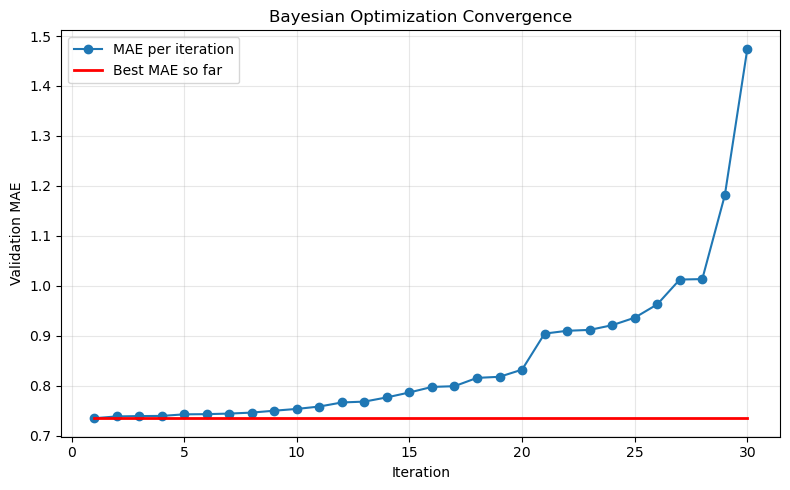

C:\Users\mrast\AppData\Local\Temp\ipykernel_26892\3307627076.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


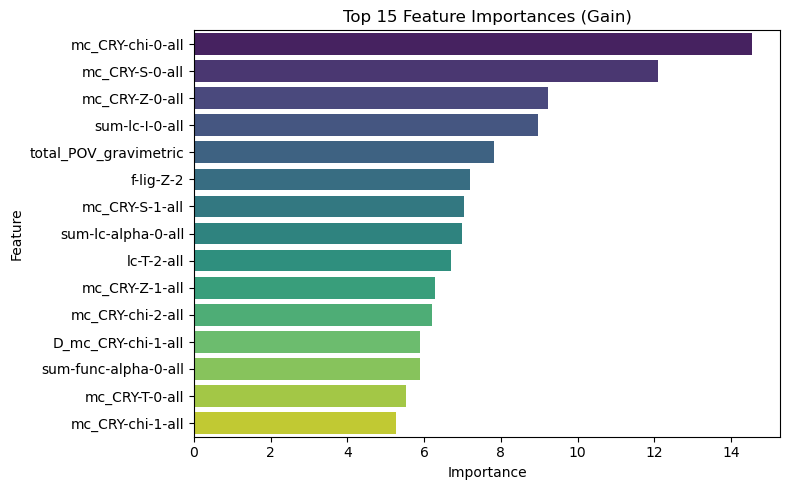


Visualization complete — convergence curve and feature importances plotted.


In [28]:
# cell6: Visualize BayesSearchCV convergence and model performance

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# Load BayesSearchCV results
try:
    df_opt = pd.read_csv("bayes_cv_results.csv")
    print(f"Loaded {len(df_opt)} BayesSearchCV iterations.")
except FileNotFoundError:
    df_opt = None
    print("⚠️ No detailed CV results found — plotting from JSON summary instead.")

# Load the tuned model info
with open("tuned_model.json", "r") as f:
    d = json.load(f)

best_params = d["bscv_result"]["best_parameters"]
best_score = d["bscv_result"]["best_score"]
subset_fraction = d.get("subset_fraction", 1.0)

print(f"\n✅ Best Bayesian optimization results:")
print(f"  - Best score (MAE): {abs(best_score):.4f}")
print(f"  - Best parameters: {best_params}")
print(f"  - Training subset fraction: {subset_fraction*100:.0f}%")

# 1️⃣ Plot Bayesian optimization convergence
if df_opt is not None:
    # Extract iteration order and test score
    df_opt_sorted = df_opt.sort_values("mean_test_score", ascending=False).reset_index(drop=True)
    df_opt_sorted["Iteration"] = np.arange(1, len(df_opt_sorted) + 1)
    best_so_far = df_opt_sorted["mean_test_score"].cummax()

    plt.figure(figsize=(8, 5))
    plt.plot(df_opt_sorted["Iteration"], -df_opt_sorted["mean_test_score"], marker="o", label="MAE per iteration")
    plt.plot(df_opt_sorted["Iteration"], -best_so_far, color="red", linewidth=2, label="Best MAE so far")
    plt.xlabel("Iteration")
    plt.ylabel("Validation MAE")
    plt.title("Bayesian Optimization Convergence")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# 2️⃣ Feature importance from final XGBoost model
try:
    model = xgb.XGBRegressor(n_estimators=100, **best_params)
    model.load_model("CO2_capture_model.json")
    importance = model.get_booster().get_score(importance_type="gain")
    importance_df = pd.DataFrame(list(importance.items()), columns=["Feature", "Importance"])
    importance_df = importance_df.sort_values("Importance", ascending=False).head(15)

    plt.figure(figsize=(8, 5))
    sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
    plt.title("Top 15 Feature Importances (Gain)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"⚠️ Could not plot feature importances: {e}")

# 3️⃣ Optional note
print("\nVisualization complete — convergence curve and feature importances plotted.")


# Run tuned model on test data and export predictions

In [ ]:
# Load tuned model info and selected features
with open("tuned_model.json", "r") as f:
    d = json.load(f)

selected_features = d["features"]
best_params = d["bscv_result"]["best_parameters"]

# Load trained model
model = xgb.XGBRegressor(n_estimators=100, **best_params)
model.load_model("CO2_capture_model.json")

# Load test data
df_test = load_test()

# Keep the first column (likely material name or ID)
first_col = df_test.columns[0]
X_test = df_test[selected_features]

# Predict
y_pred = model.predict(X_test)

# Prepare results DataFrame
df_results = pd.DataFrame({
    first_col: df_test[first_col],
    "CO2 uptake at 0.15 bar and 298K": y_pred
})

# Save to CSV
output_path = "predicted_CO2_uptake.csv"
df_results.to_csv(output_path, index=False)

print(f"✅ Predictions saved to '{output_path}'")
print(f"Preview of predictions:\n")
print(df_results.head())


✅ Predictions saved to 'predicted_CO2_uptake.csv'
Preview of predictions:

        MOFname  CO2 uptake at 0.15 bar and 298K
0  GEZYOB_clean                         2.197910
1  OKAYAC_clean                         1.436722
2  WIYWEI_clean                         2.674812
3  VUKROK_clean                         0.467149
4  IJENER_clean                         1.709240
